In [3]:
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
from collections import defaultdict

# Set the aesthetic style of the plots
sns.set(style="whitegrid")


# Analyzing the dataset

After creating the dataset using `python dataset.py` one can use this notebook to get to know the dataset better and to plot the bounding boxes. 

NOTE: Remember to edit `annotation_path` and `img_path`

In [1]:
annotation_path = "/home/taheera.ahmed/data/reindeerdrone/tiles/new_annotations.json"
img_path = "/home/taheera.ahmed/data/reindeerdrone/tiles"

In [4]:
with open(annotation_path, 'r') as file:
    data = json.load(file)
annotations = data

images = data['images']
annotations = data['annotations']
categories = {cat['id']: cat['name'] for cat in data['categories']}

In [7]:
unique_annotated_images = set()

for annotation in annotations:
    # Add the image_id from each annotation to the set, which ensures uniqueness
    unique_annotated_images.add(annotation['image_id'])

# Count of unique images that have annotations
number_of_annotated_images = len(unique_annotated_images)
print(f"Number of annotated tiles: {number_of_annotated_images}")

Number of annotated tiles: 251


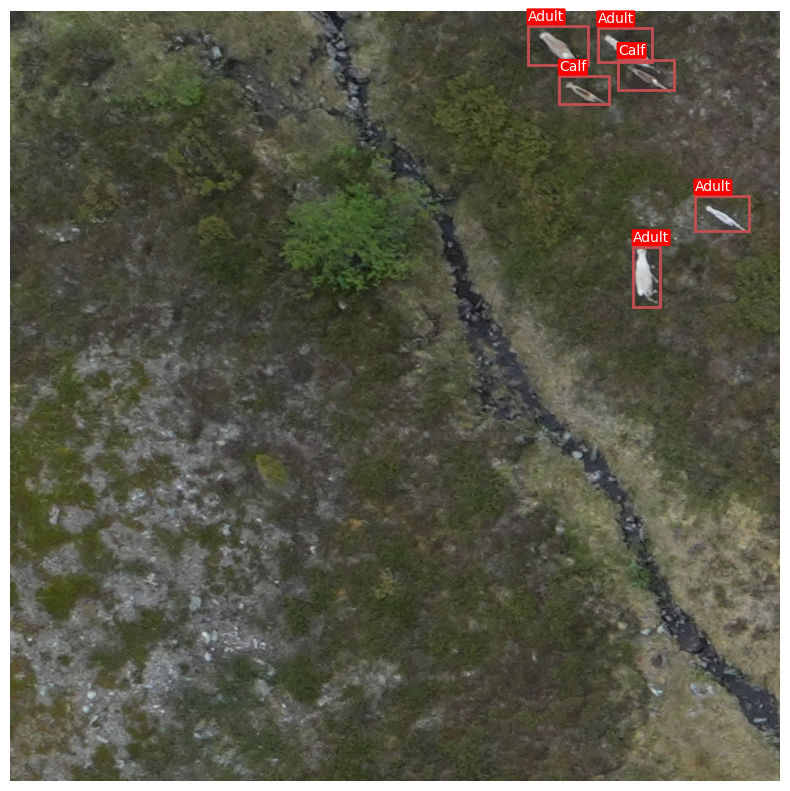

Number of bounding boxes in image DSC00408_tile1.png: 6


In [65]:
def plot_image_annotations(img_path, image_info, annotations, categories):
    # Load the image
    image_path = f"{img_path}/{image_info['file_name']}"  # Adjust the path
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    
    # Initialize bounding box counter
    bbox_count = 0
    
    # Find and plot annotations for this image
    for anno in annotations:
        if anno['image_id'] == image_info['file_name']:
            x, y, width, height = anno['bbox']
            # Clip the bounding box to the image boundaries
            x_end = min(x + width, image.shape[1])
            y_end = min(y + height, image.shape[0])
            width = x_end - x
            height = y_end - y

            # Ensure bounding box is within the image
            if x >= 0 and y >= 0 and x_end <= image.shape[1] and y_end <= image.shape[0]:
                rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                
                # Increment the bounding box counter
                bbox_count += 1
                
                # Optional: Add text label for each bbox
                label = categories.get(anno['category_id'], 'Unknown')
                # Place label above the bounding box, outside it
                label_x = x
                label_y = y - 3  # Slight vertical offset from the top of the bbox
                if label_y < 0:  # If the label goes above the image, adjust it to be just at the top inside the bbox
                    label_y = y + 3
                
                ax.text(label_x, label_y, label, color='white', fontsize=10, verticalalignment='bottom',
                        bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.1'))
    
    ax.set_axis_off()
    plt.show()

    # Print the number of bounding boxes
    print(f"Number of bounding boxes in image {image_info['file_name']}: {bbox_count}")


for image_info in images[1:2]:
    plot_image_annotations(img_path, image_info, annotations, categories)


Category Adult: 821 annotations
Category Calf: 424 annotations


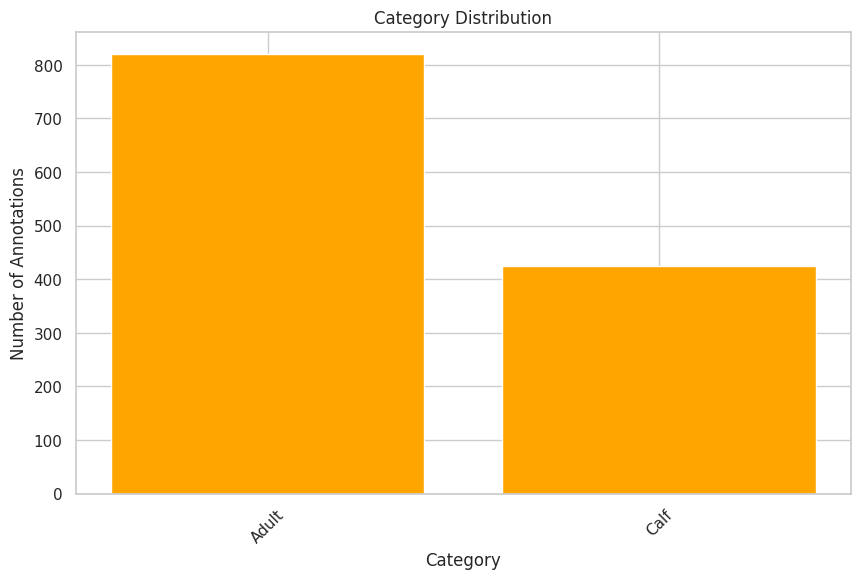

In [77]:
# Count annotations by category
category_counts = defaultdict(int)
for annotation in annotations:
    category_id = annotation['category_id']
    category_name = categories[category_id]
    category_counts[category_name] += 1

# Display the category distribution
for category, count in category_counts.items():
    print(f"Category {category}: {count} annotations")

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='orange')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


The dataset contains 1245 annotations with a noticeable skew towards adults, comprising 821 annotations, in comparison to the 424 calves. This imbalance might impact the efficacy of the object detection models, particularly in accurately identifying calves
- Maybe need targeted data augmentation.

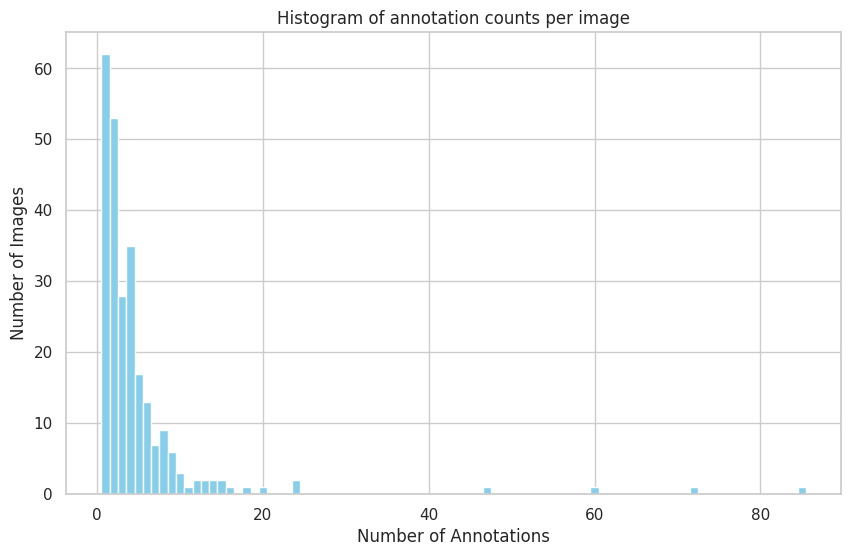

In [79]:
annotations_per_image = defaultdict(int)
for annotation in annotations:
    annotations_per_image[annotation['image_id']] += 1

plt.figure(figsize=(10, 6))
plt.hist(annotations_per_image.values(), bins=range(1, max(annotations_per_image.values()) + 2), align='left', color='skyblue')
plt.title('Histogram of annotation counts per image')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()


- Most images have relatively few objects labeled
- Maybe look at the images which as more than 20 annotations?

/tmp/ipykernel_489626/3677436141.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(category_counts, bins=bins, kde=False, palette='pastel', label=category_name, alpha=0.6)
/tmp/ipykernel_489626/3677436141.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(category_counts, bins=bins, kde=False, palette='pastel', label=category_name, alpha=0.6)


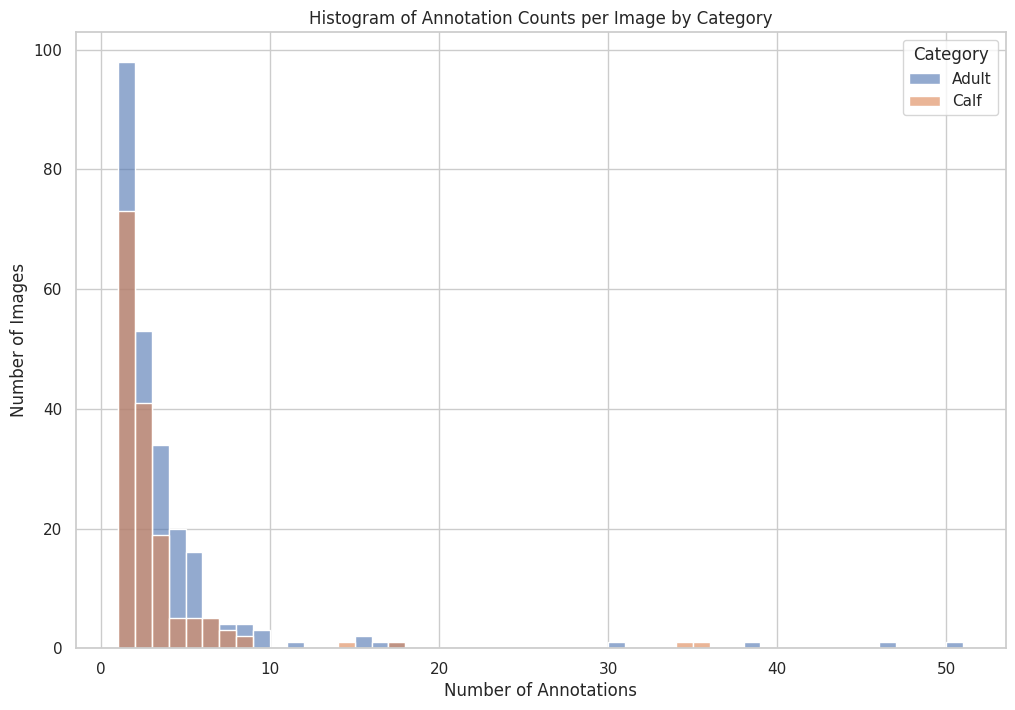

In [80]:
annotations_per_image_category = defaultdict(lambda: defaultdict(int))
for annotation in annotations:
    image_id = annotation['image_id']
    category_name = categories[annotation['category_id']]
    annotations_per_image_category[image_id][category_name] += 1

# Plotting
plt.figure(figsize=(12, 8))
max_bin = 0

# Find maximum count for consistent binning
for category_name in categories.values():
    category_counts = [counts[category_name] for counts in annotations_per_image_category.values() if category_name in counts]
    if category_counts:
        max_bin = max(max_bin, max(category_counts))

bins = range(1, max_bin + 2)

# Plot each category
for category_name in categories.values():
    category_counts = [counts[category_name] for counts in annotations_per_image_category.values() if category_name in counts]

    sns.histplot(category_counts, bins=bins, kde=False, palette='pastel', label=category_name, alpha=0.6)

plt.title('Histogram of Annotation Counts per Image by Category')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Images')
plt.legend(title='Category')
plt.grid(True)
plt.show()

It's weird that there are some images with more than 20 annotations per image, given that they are tiled. 

Average area of bounding boxes is 3376.19


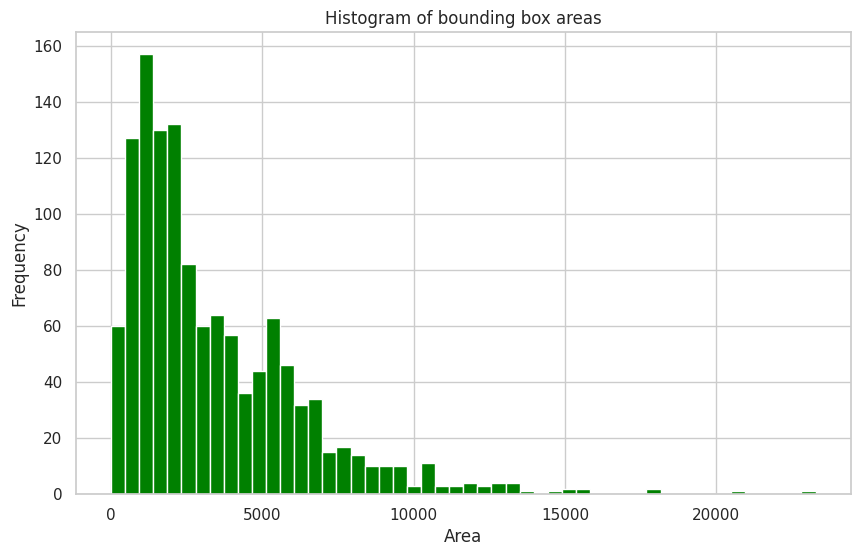

In [73]:
# Calculate average area of bounding boxes
total_area = sum(ann['area'] for ann in annotations)
average_area = total_area / len(annotations)
print(f"Average area of bounding boxes is {average_area:.2f}")

areas = [ann['area'] for ann in annotations]
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=50, color='green')
plt.title('Histogram of bounding box areas')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


There are some really big bounding boxes here as well, maybe its clever to look closer into them too.

Average aspect ratio of bounding boxes is 30.15


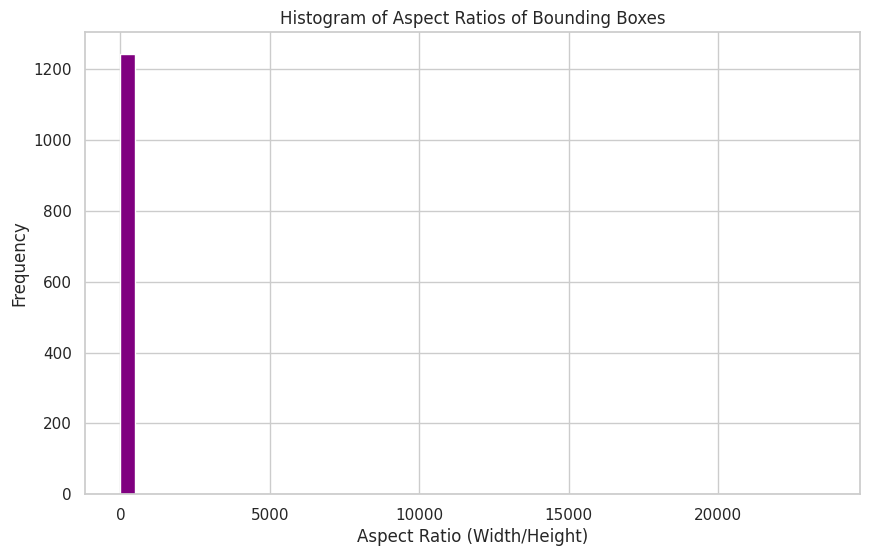

In [72]:
# Calculate aspect ratios (width/height)
aspect_ratios = []
average_aspect_ratio = sum(aspect_ratios) / len(aspect_ratios)
print(f"Average aspect ratio of bounding boxes is {average_aspect_ratio:.2f}")

plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=50, color='purple')
plt.title('Histogram of Aspect Ratios of Bounding Boxes')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
